# Problem Statement

Develop a sentiment analysis model for hospitality company reviews to classify sentiments (positive, negative, neutral) and identify key topics for actionable insights, streamlining feedback analysis.

## Objective

Create a machine learning solution capable of categorizing hospitality reviews into sentiment classes and extracting significant topics, facilitating informed decision-making and service enhancement.

### Import Libraries

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import string
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import autocorrect
from nltk.stem import PorterStemmer,WordNetLemmatizer
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from tempfile import mkdtemp
from shutil import rmtree



from sklearn.metrics import accuracy_score
import os
import joblib
from joblib import Memory
import warnings
warnings.filterwarnings('ignore')

### Load the Data

In [2]:
df = pd.read_csv(r"C:\Users\CHARISHMA\Downloads\tripadvisor_hotel_reviews.csv\tripadvisor_hotel_reviews.csv")

In [3]:
df.tail()   #Last five rows

,Review,Rating
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1
20490,"people talking, ca n't believe excellent ratin...",2


In [4]:
df.shape   #no.of rows and cols

(20491, 2)

In [5]:
df.columns   #cols names

Index(['Review', 'Rating'], dtype='object')

In [6]:
df.describe ()         #description about the dat

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [7]:
df.info()   #Information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [8]:
# Check for missing values
print(df.isnull().sum())

Review    0
Rating    0
dtype: int64


## Data Visualization

### Distribution Analysis

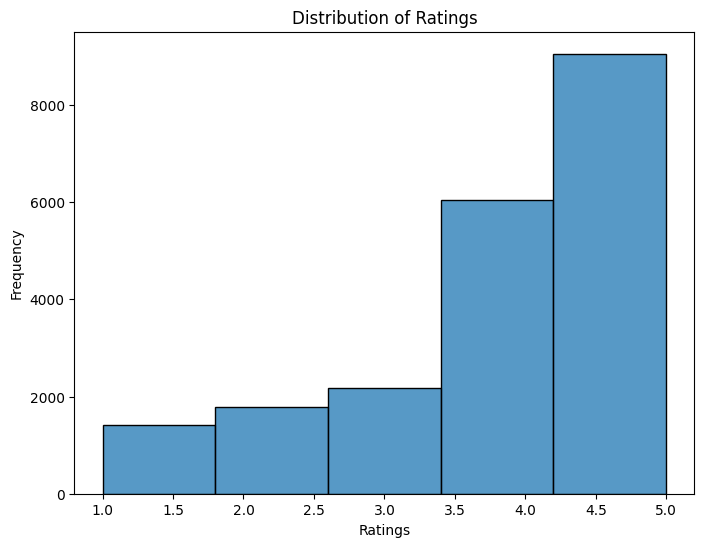

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=5, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

There are more ratings related to 4 and 5

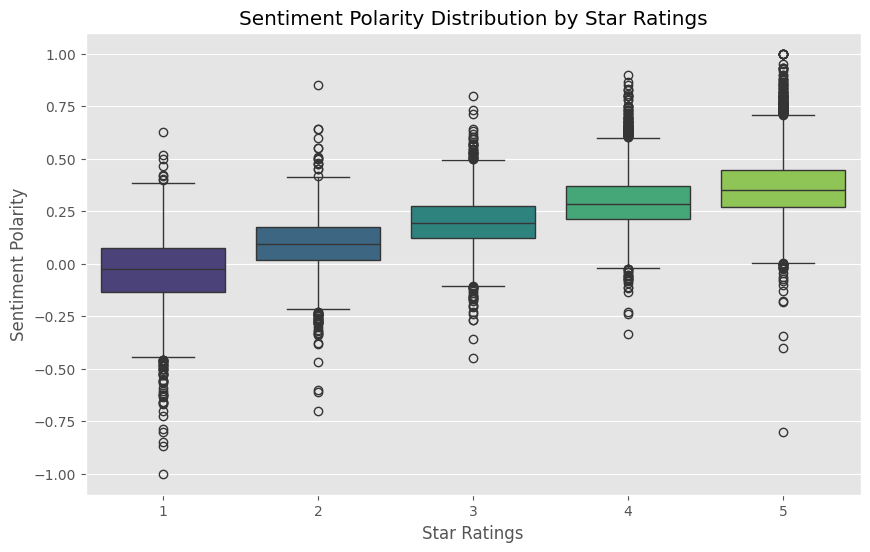

In [48]:
from textblob import TextBlob

df['Sentiment_Polarity'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.boxplot(x='Rating', y='Sentiment_Polarity', data=df, palette='viridis')
plt.title('Sentiment Polarity Distribution by Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Sentiment Polarity')
plt.show()


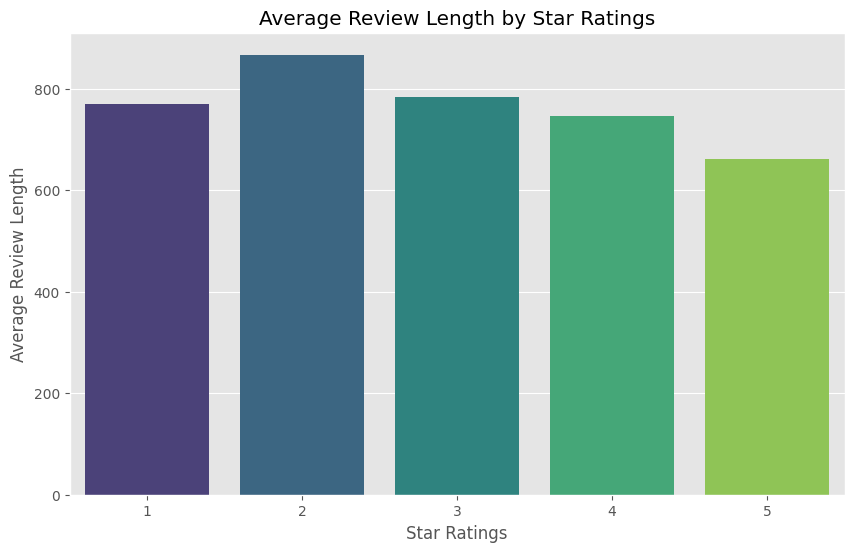

In [49]:
df['Review_Length'] = df['Review'].apply(len)

avg_review_length = df.groupby('Rating')['Review_Length'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='Rating', y='Review_Length', data=avg_review_length, palette='viridis')
plt.title('Average Review Length by Star Ratings')
plt.xlabel('Star Ratings')
plt.ylabel('Average Review Length')
plt.show()

We can observe here negative reviews have more length

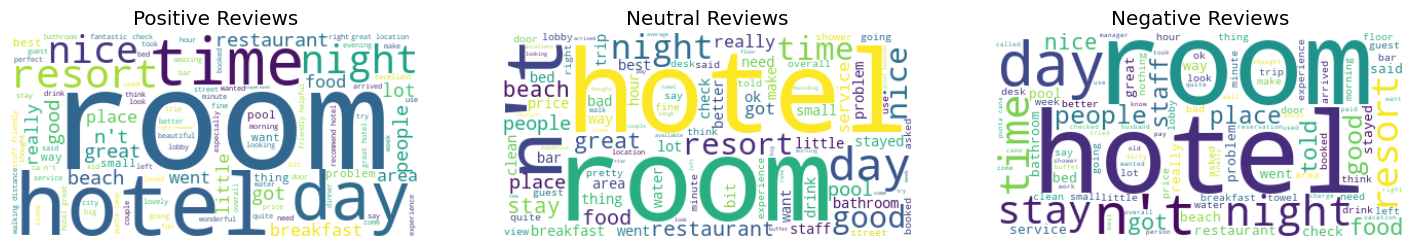

In [50]:
positive_reviews = " ".join(review for review in df[df['Rating'] >= 4].Review)
neutral_reviews = " ".join(review for review in df[df['Rating'] == 3].Review)
negative_reviews = " ".join(review for review in df[df['Rating'] <= 2].Review)

positive_wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='green').generate(positive_reviews)
neutral_wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='orange').generate(neutral_reviews)
negative_wordcloud = WordCloud(background_color='white', max_words=100, contour_width=3, contour_color='red').generate(negative_reviews)

plt.figure(figsize=(18,12))

plt.subplot(1, 3, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 3, 2)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Reviews')

plt.subplot(1, 3, 3)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()

## Sentiment Analysis on Text Data

In [10]:
def get_sentiment_nltk(rating):
    if rating >= 4:
        return 'Positive'
    elif rating < 3:
        return 'Negative'
    else:
        return 'Neutral'

In [11]:
df['Sentiment'] = df['Rating'].apply(get_sentiment_nltk)

In [12]:
df

,Review,Rating,Sentiment
0,nice hotel expensive parking got good deal sta...,4,Positive
1,ok nothing special charge diamond member hilto...,2,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,Positive
4,"great stay great stay, went seahawk game aweso...",5,Positive
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,Positive
20487,great location price view hotel great quick pl...,4,Positive
20488,"ok just looks nice modern outside, desk staff ...",2,Negative
20489,hotel theft ruined vacation hotel opened sept ...,1,Negative


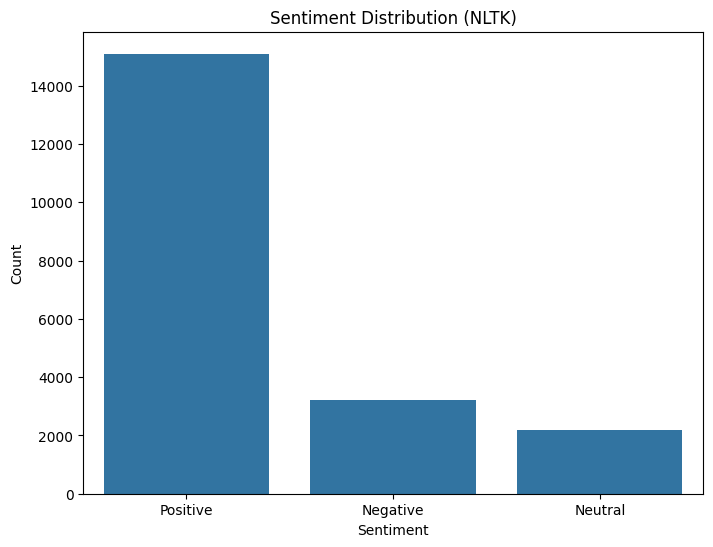

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

There are more positive reviews

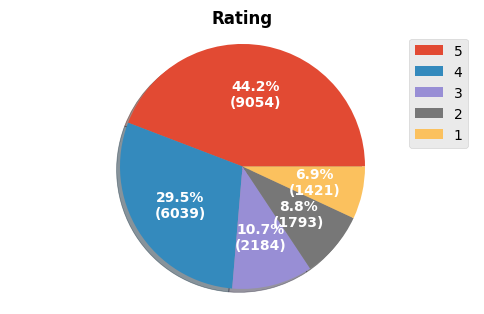

In [14]:
plt.style.use('ggplot')

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(figsize = (6,3.5))
df_class = df['Rating'].value_counts().to_frame()
labels = df_class.index
values = df_class.iloc[:,0].to_list()
ax.pie(x = values, labels = labels, autopct = autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':10, 'fontweight':'bold'})
ax.legend(labels, loc = 'best')
ax.set_title('Rating', fontsize = 12, fontweight = "bold", color = "black")
ax.axis('equal')

fig.show()

### Text Data

In [15]:
# Distribution of Target Variable
df['Sentiment'].value_counts(normalize=True)

Sentiment
Positive    0.736567
Negative    0.156849
Neutral     0.106583
Name: proportion, dtype: float64

In [16]:
df.loc[0, 'Review'] #Read one review

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

In [17]:
sentiment_mapping = {'Positive': 1, 'Negative': 0,'Neutral':2}
df['Sentiment_numeric'] = df['Sentiment'].map(sentiment_mapping)
print(df[['Sentiment', 'Sentiment_numeric']].head())

  Sentiment  Sentiment_numeric
0  Positive                  1
1  Negative                  0
2   Neutral                  2
3  Positive                  1
4  Positive                  1


## Step-1 - Identify Input and Output

In [18]:
X = df.Review 
y = df.Sentiment_numeric
print(X.shape, y.shape)

(20491,) (20491,)


## Step-2 - Split the Data into train and test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15368,) (15368,)
(5123,) (5123,)


## Step 3 : Data Preprocessing on train data (X_train)

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def display_wordcloud(data):
    wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(data))
    plt.figure(1,figsize=(30,20))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

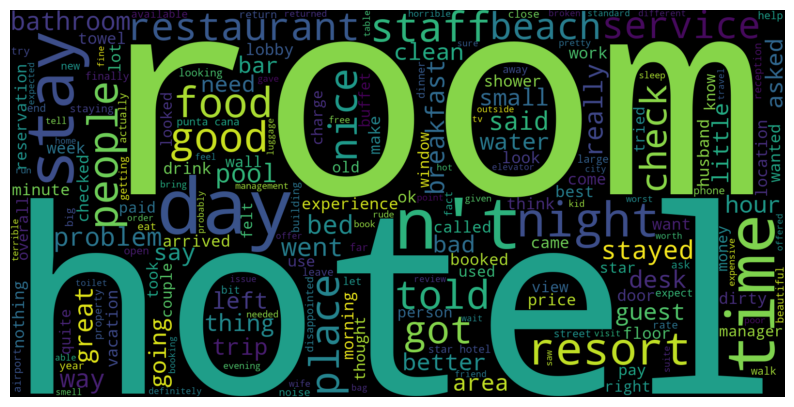

In [21]:
from wordcloud import WordCloud
#Negative Reviews
# Function to display word cloud
def display_wordcloud(data):
    wc = WordCloud(background_color='black', width=1600, height=800).generate(' '.join(data))

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

display_wordcloud(X_train[y_train ==0])


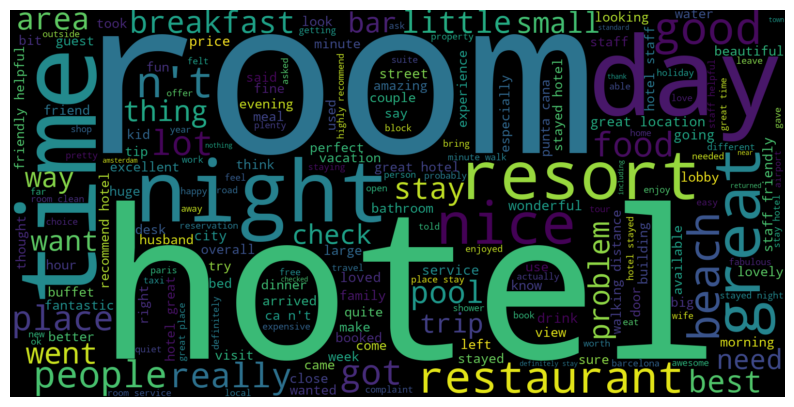

In [22]:
#positive Reviews
display_wordcloud(X_train[y_train==1])

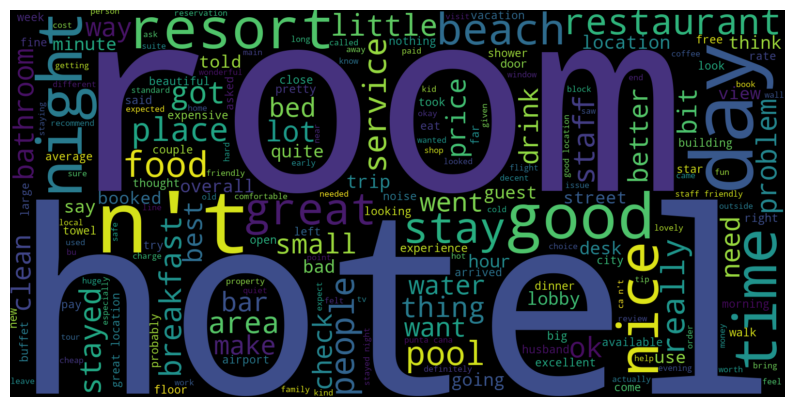

In [23]:
# neutral reviews
display_wordcloud(X_train[y_train==2])

In [24]:
import string
from nltk.stem import WordNetLemmatizer

# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [25]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\CHARISHMA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
def clean(doc): # doc is a string of text
    # This text contains a lot of <br/> tags.
    doc = doc.replace("</br>", " ")
    
    # Remove punctuation and numbers.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    doc = doc.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(doc)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(preprocessor=clean)
%time X_train_dtm = vect.fit_transform(X_train)
print(X_train_dtm.shape)

CPU times: total: 21.3 s
Wall time: 24.3 s
(15368, 59848)


## Step 4 - Data Preprocessing on test data (X_test)

In [28]:
X_test_dtm = vect.transform(X_test)
print(X_test_dtm.shape)

(5123, 59848)


## Step 5 - Building a Model (i.e. Train the classifier)

In [29]:
nb = MultinomialNB() 
%time nb.fit(X_train_dtm, y_train) 

CPU times: total: 15.6 ms
Wall time: 18.4 ms


MultinomialNB()

## Step 6 - Evaluating on Train Data

In [30]:
from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.accuracy_score(y_train, y_train_pred)

0.8925689744924519

In [31]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[ 1983,   373,    10],
       [   94, 11232,    14],
       [  155,  1005,   502]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

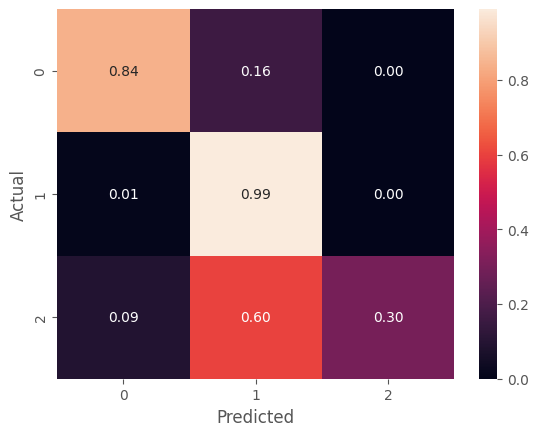

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')


## Step 7 - Evaluate on Test Data

In [33]:
y_test_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_test_pred)

0.8465742728869803

Text(0.5, 23.52222222222222, 'Predicted')

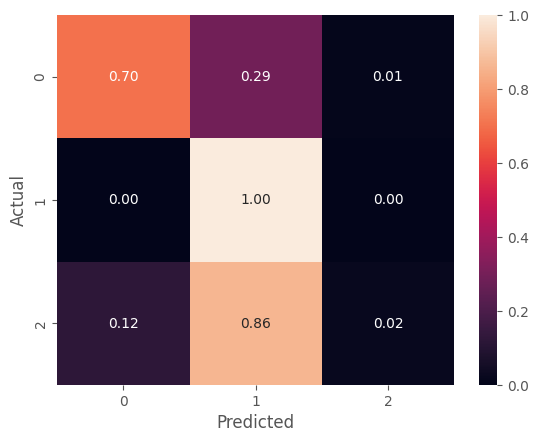

In [34]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [35]:
print("Train Score (accuracy_score):", metrics.accuracy_score(y_train, y_train_pred))
print("Test Score (accuracy_score):", metrics.accuracy_score(y_test, y_test_pred))

Train Score (F1 Score - Micro): 0.8925689744924519
Test Score (F1 Score - Micro): 0.8465742728869803


In [36]:
# Improving the efficiency by applying cleaning the text data before hand

%time X_train_clean = X_train.apply(lambda doc: clean(doc))

CPU times: total: 17.4 s
Wall time: 19.8 s


In [37]:
%time X_test_clean = X_test.apply(lambda doc: clean(doc))

CPU times: total: 5.75 s
Wall time: 6.36 s


Well, Naive Bayes is giving good result, lets start with remaining algorithms

## Pipeline

In [38]:
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory),
    'xgboost': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', XGBClassifier())
    ], memory=memory)
}

param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000], 
            'classifier__C': [0.1, 1], 
            'classifier__penalty': ['l2'],  # Use only L2 penalty for logistic regression
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ],
    'xgboost': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 2000, 5000], 
            'classifier__max_depth': [3],
            'classifier__learning_rate': [0.1],
            'classifier__n_estimators': [60]  # Limit the number of estimators to 60
        }
    ]
}

best_models = {}

for algo in pipelines.keys():
    print("*" * 10, algo, "*" * 10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='accuracy', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(X_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test_clean, y_test))


********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 54.3 s
Wall time: 1min 2s
Score on Test Data:  0.8434511028694125
********** logistic_regression **********
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 2min 51s
Wall time: 3min 19s
Score on Test Data:  0.8049970720281086
********** xgboost **********
Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: total: 16min 11s
Wall time: 3min 27s
Score on Test Data:  0.8003123170017568


In [39]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', MultinomialNB(alpha=10))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=2000)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced',
                                    solver='saga'))])

xgboost
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=1000)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
    

In [45]:
for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    joblib.dump(model, f'C:\\Users\\CHARISHMA\\job\\Sentiment Analysis\\{name}.pkl')
    model = joblib.load(f'C:\\Users\\CHARISHMA\\job\\Sentiment Analysis\\{name}.pkl')
    
    %time y_test_pred = model.predict(X_test_clean)
    print("Test Score (accuracy)", metrics.accuracy_score(y_test, y_test_pred))
    
    print("Model Size:", os.path.getsize(f'C:\\Users\\CHARISHMA\\job\\Sentiment Analysis\\{name}.pkl'), "Bytes")

********** naive_bayes **********
CPU times: total: 359 ms
Wall time: 397 ms
Test Score (accuracy) 0.8434511028694125
Model Size: 1042095 Bytes
********** logistic_regression **********
CPU times: total: 344 ms
Wall time: 431 ms
Test Score (accuracy) 0.8049970720281086
Model Size: 787114 Bytes
********** xgboost **********
CPU times: total: 922 ms
Wall time: 417 ms
Test Score (accuracy) 0.8003123170017568
Model Size: 944724 Bytes


##### All the three models are giving approximately same accuracy, I have Deployed the model with Xgboost
* Based on Model Size and
* Based on performance also